In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

## Helpers

In [2]:
def plot_vectors(vectors=[(0, 0, 1, 2),(0, 0, 3, 1)], 
                 texts=[r'$\vec{a}$', r'$\vec{b}$', 'power vec', 'power vec2'], 
                 texts_locs=[(0.5, 0.7), (0.2, 0.8), (0.7, 0.5),  (0.5, 0.5)], text_size=18, 
                 colors=["#2EBCE7","#00E64E", "purple", 'orange'],   
                 xlim=(-1, 3), ylim=(-1,3), x_label='x', y_label='y', 
                 scale=1, scale_units='xy'):
    fig, ax =plt.subplots(figsize=(6,6))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    for i, vec in enumerate(vectors):
        ax.quiver(*vec, color=colors[i], angles='xy', scale_units=scale_units, scale=scale)
        plt.text(*texts_locs[i], texts[i], color=colors[i], size=text_size)

    # draw axes
    plt.axhline(0, c='#d6d6d6', zorder=0)
    plt.axvline(0, c='#d6d6d6', zorder=0)

    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return ax

#from https://en.wikipedia.org/wiki/Power_iteration
def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

## SVD methods, beer example

#### Beer dataset

Data is available from here: https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo

In [11]:
df=pd.read_csv('data/beer_dataset.csv')
df.shape

(365, 7)

In [223]:
def plot_beer(x, y, x_label="Maximal temperature ($\degree$C)", y_label="Consuption (liters)", 
              alpha=0.3, draw_axes=False):
    plt.scatter(x, y, alpha=alpha)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Assure that ticks are displayed with a specific step
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    if draw_axes:
        # draw axes
        plt.axhline(0, c='#d6d6d6', zorder=0)
        plt.axvline(0, c='#d6d6d6', zorder=0)

    # assure x and y axis have the same scale
    plt.axis('equal')
    plt.show()

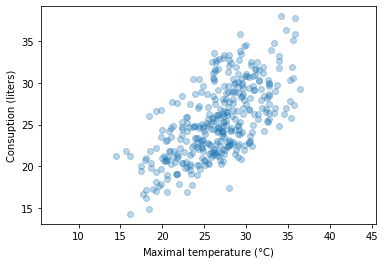

In [224]:
plot_beer(df['Temperatura Maxima (C)'],
          df['Consumo de cerveja (litros)'])

#### Make datasets

In [225]:
X = np.array([df['Temperatura Maxima (C)'],
              df['Consumo de cerveja (litros)']]).T

#### Covariance matrix

In [226]:
C = np.cov(X, rowvar=False)
C

array([[18.63964745, 12.20609082],
       [12.20609082, 19.35245652]])

In [227]:
#for easier plotting calculate mean centered data
X_norm=X.copy()
X_norm -= X.mean(axis=0)

## Version 1  - power iteration

In [204]:
#source http://mlwiki.org/index.php/Power_Iteration
def eigenvalue(A, v):
    val = A @ v / v
    return val[0]

def svd_power_iteration(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = eigenvalue(A, v)

    while True:
        Av = A @ v
        v_new = Av / np.linalg.norm(Av)
        ev_new = eigenvalue(A, v_new)
        if np.abs(ev - ev_new) < 0.01:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

In [205]:
eigen_value, eigen_vec = svd_power_iteration(C)
eigen_value

31.206525014487084

In [207]:
eigen_vec

array([0.69673479, 0.71732882])

In [249]:
#compare to numpy implementation
u, s, v=np.linalg.svd(C, 1)

In [250]:
u # first eigenvector matches, we can ignore the signs as they are still same eigenvector

array([[-0.69671139, -0.71735154],
       [-0.71735154,  0.69671139]])

In [251]:
s #numpy has second eigenvalue also

array([31.20734501,  6.78475896])

In [252]:
v

array([[-0.69671139, -0.71735154],
       [-0.71735154,  0.69671139]])

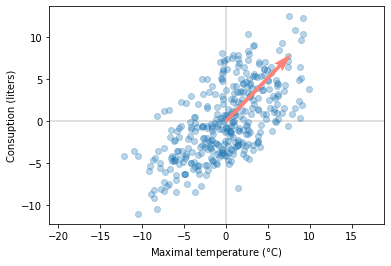

In [237]:
#lets plot dominant eigenvector
def plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"]):
    for i, eigen_vec in enumerate(eigen_vecs):
        plt.quiver(0, 0,
           2 * np.sqrt(eigen_values[i]) * eigen_vec[0], 2 * np.sqrt(eigen_values[i]) * eigen_vec[1],
           color=colors[i], angles="xy", scale_units="xy", scale=1,
           zorder=2, width=0.011)

plot_eigenvectors([eigen_vec], [eigen_value], colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)

## Version 2  - svd for n singular values

In [238]:
#https://jeremykun.com/2016/05/16/singular-value-decomposition-part-2-theorem-proof-algorithm/
#https://github.com/j2kun/svd/blob/main/svd.py
def eigenvalue(A, v):
    val = A @ v / v
    return val[0]

def svd_power_iteration(A, epsilon=0.01):
    """returns dominant eigenvalue and dominant eigenvector of matrix A"""
    n, m = A.shape
    k=min(n,m)
    v = np.ones(k) / np.sqrt(k)
    if n > m:
        A = A.T @ A
    elif n < m:
        A = A @ A.T
    
    ev = eigenvalue(A, v)

    while True:
        Av = A@ v
        v_new = Av / np.linalg.norm(Av)
        ev_new = eigenvalue(A, v_new)
        if np.abs(ev - ev_new) < epsilon:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

def svd(A, k=None, epsilon=1e-10):
    """returns k dominant eigenvalues and eigenvectors of matrix A"""
    A = np.array(A, dtype=float)
    n, m = A.shape
        
    svd_so_far = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_for_1d = A.copy()

        for singular_value, u, v in svd_so_far[:i]:
            matrix_for_1d -= singular_value * np.outer(u, v)

        if n > m:
            _, v = svd_power_iteration(matrix_for_1d, epsilon=epsilon)  # next singular vector
            u_unnormalized = A @ v
            sigma = np.linalg.norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            _, u = svd_power_iteration(matrix_for_1d, epsilon=epsilon)  # next singular vector
            v_unnormalized = A.T @ u
            sigma = np.linalg.norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svd_so_far.append((sigma, u, v))

    singular_values, us, vs = [np.array(x) for x in zip(*svd_so_far)]
    return singular_values, us.T, vs

In [239]:
eigen_values, eigen_vecs, _ = svd(C)

In [240]:
eigen_values

array([31.20734501,  6.78475896])

In [241]:
eigen_vecs

array([[ 0.69671139,  0.71735154],
       [ 0.71735154, -0.69671139]])

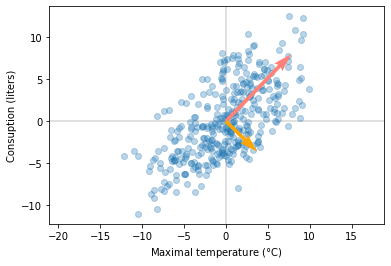

In [242]:
plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)

In [214]:
mat=np.array([[1,2,3],
            [4,5,6]])
mat

array([[1, 2, 3],
       [4, 5, 6]])

In [215]:
np.linalg.svd(mat)

(array([[-0.3863177 , -0.92236578],
        [-0.92236578,  0.3863177 ]]),
 array([9.508032  , 0.77286964]),
 array([[-0.42866713, -0.56630692, -0.7039467 ],
        [ 0.80596391,  0.11238241, -0.58119908],
        [ 0.40824829, -0.81649658,  0.40824829]]))

In [216]:
svd(mat)

(array([9.508032  , 0.77286964]),
 array([[ 0.3863177 ,  0.92236578],
        [ 0.92236578, -0.3863177 ]]),
 array([[ 0.42866713,  0.56630692,  0.7039467 ],
        [-0.80596391, -0.11238241,  0.58119908]]))

In [217]:
mat2=np.array([[1,2,3],
            [4,5,6],
              [6,1,9],
              [3,2,3]])
mat2

array([[1, 2, 3],
       [4, 5, 6],
       [6, 1, 9],
       [3, 2, 3]])

In [218]:
np.linalg.svd(mat2, full_matrices=False)

(array([[-0.23977259, -0.25783455, -0.70262188],
        [-0.5731924 , -0.66688394,  0.02172421],
        [-0.71887238,  0.68282973, -0.08897351],
        [-0.31174039, -0.15010236,  0.70564458]]),
 array([14.7049491 ,  3.65932101,  1.17210996]),
 array([[-0.52914142, -0.31879473, -0.78637095],
        [ 0.19711333, -0.94757027,  0.25150927],
        [ 0.82532157,  0.02192023, -0.56423737]]))

In [219]:
svd(mat2)

(array([14.7049491 ,  3.65932101,  1.17210996]),
 array([[ 0.23977259,  0.25783455, -0.70262188],
        [ 0.5731924 ,  0.66688394,  0.02172421],
        [ 0.71887238, -0.68282973, -0.08897351],
        [ 0.31174039,  0.15010236,  0.70564458]]),
 array([[ 0.52914142,  0.31879473,  0.78637095],
        [-0.19711333,  0.94757027, -0.25150927],
        [ 0.82532157,  0.02192023, -0.56423737]]))

## Simultaneous power iteration /Orthogonal Iteration / block version of the Power Method

In [243]:
def simultaneous_power_iteration(A, k, epsilon=0.001):
    n, m = A.shape
    Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
 
    for i in range(1000):
        Z = A @ Q
        Q, R = np.linalg.qr(Z)

        # can use other stopping criteria as well 
        err = ((Q - Q_prev) ** 2).sum()

        Q_prev = Q
        if err < epsilon:
            break

    return np.diag(R), Q.T

In [244]:
eigen_values, eigen_vecs = simultaneous_power_iteration(C, 2)

In [245]:
eigen_values

array([31.20623454,  6.7850004 ])

In [246]:
eigen_vecs

array([[-0.69805812, -0.71604111],
       [-0.71604111,  0.69805812]])

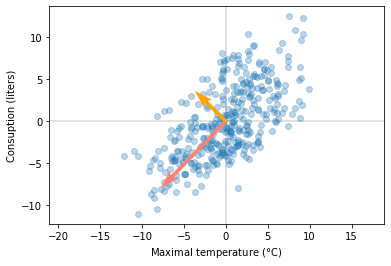

In [247]:
plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)